In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

<h1>Polynomial Regression and regularization</h1>

<h2>1. Generating synthetic data</h2>

In [30]:
rng = np.random.default_rng(42)
deg = 5

x_points = np.linspace(-10,10,126)
w_ = rng.uniform(size = deg + 1)

y_points = sum(w_[i] * x_points ** (deg - i) for i in range(deg+1))

noisify = lambda x_points,sc : rng.normal(loc =0., size = len(x_points),scale = (np.max(x_points) - np.min(x_points))/ len(x_points) * sc)

x_points += noisify(x_points,3)
y_points += noisify(y_points,4)

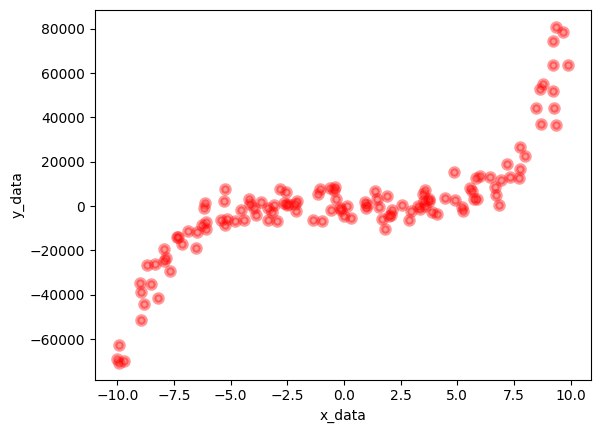

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x_points,y_points,alpha = 0.4,lw = 3,color = "red")
ax.set_xlabel("x_data")
ax.set_ylabel("y_data")
plt.show()

Dataset

In [32]:
data_set = {"features" : DataFrame({f"x^{deg - i}" : x_points**(deg - i) for i in range(deg)}), "target" : Series(y_points)}

In [33]:
data_set["features"][:5]

,x^5,x^4,x^3,x^2,x^1
0,-96993.015298,9758.709020,-981.848038,98.786178,-9.939124
1,-99530.469859,9962.419919,-997.180168,99.811923,-9.990592
2,-85343.563786,8809.203028,-909.290104,93.857355,-9.688001
3,-96364.617007,9708.096391,-978.026359,98.529673,-9.926211
4,-57146.354805,6391.323890,-714.814115,79.945756,-8.941239


In [34]:
data_set["target"][:5]

0   -70639.849050
1   -69138.973115
2   -69947.659803
3   -62638.909634
4   -51319.234054
dtype: float64

In [35]:
X_data = data_set["features"].to_numpy()
print(X_data.shape)

y_data = data_set["target"].to_numpy()
print(y_data.shape)

(126, 5)
(126,)


In [36]:
n,_ = X_data.shape
train_rate = 0.7

rng = np.random.default_rng(42)
inds = rng.choice(n,int(train_rate * n))
inds_prime = np.array([i for i in range(n) if not (i in inds)])

X_train, X_test, y_train, y_test = X_data[inds],X_data[inds_prime],y_data[inds],y_data[inds_prime]

print("training features : ",X_train.shape)
print("training targets : ",y_train.shape)
print("testing features : ",X_test.shape)
print("testing targets : ",y_test.shape)

training features :  (88, 5)
training targets :  (88,)
testing features :  (66, 5)
testing targets :  (66,)


<h2>2. Training model</h2>

In [37]:
from FlowControl import LinearRegression_cf

In [38]:
model1 = LinearRegression_cf(alpha=1e-10,steps = 100000)
w_t1 = model1.fit(X_train,y_train,batch_size=X_train.shape[0],scale_features = False)
print(w_t1)

[ 0.79366936  0.62793512  0.1262639  -0.03138001 -0.18994766 -0.13691093]


In [39]:
model2 = LinearRegression_cf(alpha=1e-2,steps = 500000)
w_t2 = model2.fit(X_train,y_train,batch_size=X_train.shape[0],scale_features = True)
print(w_t2)

[   0.81389543    2.36916785   -5.3420255  -121.46428758  266.22821357
  104.04263477]


In [40]:
w_t3 = model2.fit(X_train,y_train,batch_size=X_train.shape[0]//5,scale_features = True)
print(w_t3)

[   0.81394388    2.28800816   -4.77501082 -126.52152466  283.5962593
  257.13016222]


In [41]:
from sklearn.linear_model import LinearRegression

model_sk = LinearRegression()
model_sk.fit(X_train,y_train)

w_sk = model_sk.coef_
b_sk = model_sk.intercept_

print(w_sk,b_sk)

[   0.81653372    2.38086652   -5.21227396 -125.22377091  256.94152588] 170.6058428452609


In [42]:
ref_x = np.arange(-10,10,0.1)
poly_1 = sum(ref_x ** (deg - i) * w_t1[i] for i in range(deg)) + w_t1[-1]
poly_2 = sum(ref_x ** (deg - i) * w_t2[i] for i in range(deg)) + w_t2[-1]
poly_3 = sum(ref_x ** (deg - i) * w_t3[i] for i in range(deg)) + w_t3[-1]
poly_4 = sum(ref_x ** (deg - i) * w_sk[i] for i in range(deg)) + b_sk

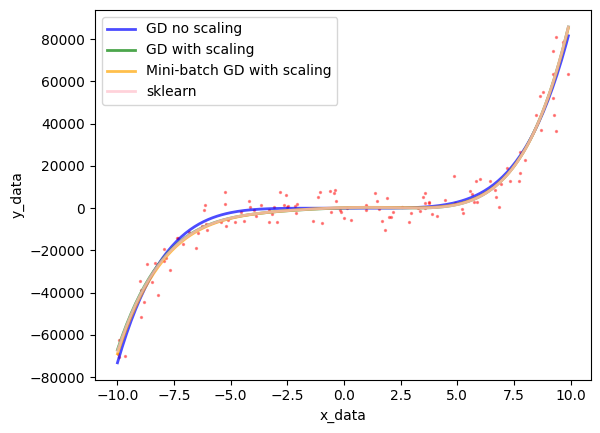

In [43]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x_points,y_points,alpha = 0.4,s = 2,color = "red")
ax.plot(ref_x,poly_1,color = "blue",alpha = 0.7,lw = 2,label = "GD no scaling")
ax.plot(ref_x,poly_2,color = "green",alpha = 0.7,lw = 2,label = "GD with scaling")
ax.plot(ref_x,poly_3,color = "orange",alpha = 0.7,lw = 2,label = "Mini-batch GD with scaling")
ax.plot(ref_x,poly_4,color = "pink",alpha = 0.7,lw = 2,label = "sklearn")
ax.set_xlabel("x_data")
ax.set_ylabel("y_data")
ax.legend()
plt.show()

<h2>3. Regularization</h2>

In [44]:
from FlowControl import add_to_class

class LinearRegression_regularization(LinearRegression_cf):
    def __init__(self,alpha = 0.01,steps = 1000,lam = 0.01):
        super().__init__(alpha,steps)
        self.lam = lam

    def batch_grad(self,X,y,B):
        return super().batch_grad(X,y,B) - self.Regularization_grad()
    
    def Cost_function(self,X,y):
        return super().Cost_function(X,y) + self.Regularization_fun()
    
    def Regularization_grad(self):
        raise NotImplementedError
    
    def Regularization_fun(self):
        raise NotImplementedError

<h3>3.1 Lagrange multipliers</h3>

Task: 
find an extremum of a given function $f(\vec{x})$ with additional constraint $g(\vec{x}) = c$
1. $\vec{\nabla}g(\vec{x})$ points in the direction in which $g(\vec{x})$ is changing.
2. $\vec{\nabla}f(\vec{x})$ points in the direction of the fastest growth of the $f(\vec{x})$.

Each infinitizemal vector $d\vec{x}$ can be decomposed into two parts: $d\vec{x}_{t} + d\vec{x}_{n}$ tangent and normal to the $g(\vec{x}) = c$ hypersurface. 
- $\vec{\nabla}g(\vec{x})\cdot d\vec{x}_{t} = 0$ for every $\vec{x}$
- if $\vec{x}$ minimize the function $f$ according to our constraint, then $\vec{\nabla}f\cdot d\vec{x}_{t} = 0$

Because one constraint should correspond only to the one-dimensional hyperspace, then vectors: $\vec{\nabla}f$ and $\vec{\nabla}g$ should be lineary dependent:
$$
\vec{\nabla}f +\lambda \vec{\nabla}g = 0
$$
for some $\lambda$. therefore our problem can be reduced to minimization fo the function 
$$
h = f + \lambda g
$$
We can always find the minimizing $\vec{x}$ as a function of $\lambda$. Then we can find the **hyperparameter** $\lambda$ for the equation: $g(\vec{x}(\lambda)) = c$

Above reasoning can be easily extended for the case of multiple constraints:
$$
h = f + \sum_{k=1}^{N} \lambda_{k}g_{k}
$$

and also for the case of constraints composed of inequality.  

<h3>3.2 Lasso regression</h3>

Let's suppose that our problem is additionally constrained by one more condition:
$$
\sum_{k=1}^{d+1}|\omega_{k}| < t
$$
which is equivalent to:
$$
||\vec{\omega}||_{1} < t
$$

We can take into account this constraint by minimizing different Cost function with Lagrange multiplyier:
$$
\mathcal{L}(\vec{\omega}) = \frac{1}{2n}\sum_{i=1}^{n}(\hat{y}^{(i)} - \vec{\omega} \cdot \vec{x}^{(i)})^{2} + \lambda \sum_{k = 1}^{d+1}|w_{k}|
$$

Additional gradient term:
$$
\vec{\nabla}\mathcal{L}_{lasso} =\vec{\nabla}\mathcal{L} + \lambda \sigma(\vec{w})
$$

In [45]:
class Lasso_(LinearRegression_regularization):
    def Regularization_grad(self):
        return self.lam * np.sign(self.w_)
    
    def Regularization_fun(self):
        return self.lam * sum(np.abs(self.w_))

In [46]:
def run_lasso(lam):
    model_lasso = Lasso_(alpha=1e-2,steps = 500000,lam = lam)
    return model_lasso.fit(X_train,y_train,batch_size=X_train.shape[0],scale_features = True)

In [47]:
w_t_lasso_1 = run_lasso(70)
w_t_lasso_2 = run_lasso(10)
w_t_lasso_3 = run_lasso(0.1)

ref_x_2 = np.arange(-10,10,0.1)
poly_1_2 = sum(ref_x ** (deg - i) * w_t_lasso_1[i] for i in range(deg)) + w_t_lasso_1[-1]
poly_2_2 = sum(ref_x ** (deg - i) * w_t_lasso_2[i] for i in range(deg)) + w_t_lasso_2[-1]
poly_3_2 = sum(ref_x ** (deg - i) * w_t_lasso_3[i] for i in range(deg)) + w_t_lasso_3[-1]


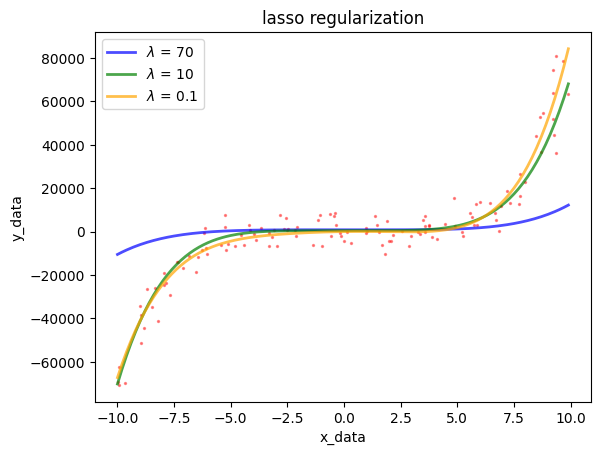

In [48]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x_points,y_points,alpha = 0.4,s = 2,color = "red")
ax.set_title("lasso regularization")
ax.plot(ref_x,poly_1_2,color = "blue",alpha = 0.7,lw = 2,label = r"$\lambda$ = 70")
ax.plot(ref_x,poly_2_2,color = "green",alpha = 0.7,lw = 2,label = r"$\lambda$ = 10")
ax.plot(ref_x,poly_3_2,color = "orange",alpha = 0.7,lw = 2,label = r"$\lambda$ = 0.1")
#ax.plot(ref_x,poly_4_2,color = "pink",alpha = 0.7,lw = 2,label = "sklearn")
ax.set_xlabel("x_data")
ax.set_ylabel("y_data")
ax.legend()
plt.show()

<h3>3.3 Ridge regression</h3>

Let us now suppose that our problem is additionally constrained by condition
$$
\sum_{k=1}^{d+1}\omega_{k}^{2} < t
$$
which is equivalent to:
$$
||\vec{\omega}||_{2} < t
$$

We can take into account this constraint by minimizing different Cost function with Lagrange multiplyier:
$$
\mathcal{L}(\vec{\omega}) = \frac{1}{2n}\sum_{i=1}^{n}(\hat{y}^{(i)} - \vec{\omega} \cdot \vec{x}^{(i)})^{2} + \lambda \sum_{k = 1}^{d+1}|w_{k}|^{2}
$$

Additional gradient term:
$$
\vec{\nabla}\mathcal{L}_{ridge} =\vec{\nabla}\mathcal{L} + 2\lambda \vec{\omega}
$$

In [49]:
class Ridge_(LinearRegression_regularization):
    def Regularization_grad(self):
        return 2* self.lam * self.w_
    
    def Regularization_fun(self):
        return self.lam * sum(np.abs(self.w_)**2)

In [50]:
def run_ridge(lam):
    model_r = Ridge_(alpha=1e-2,steps = 500000,lam = lam)
    return model_r.fit(X_train,y_train,batch_size=X_train.shape[0],scale_features = True)

In [51]:
w_t_ridge_1 = run_ridge(70)
w_t_ridge_2 = run_ridge(10)
w_t_ridge_3 = run_ridge(0.1)

ref_x_3 = np.arange(-10,10,0.1)
poly_1_3 = sum(ref_x ** (deg - i) * w_t_ridge_1[i] for i in range(deg)) + w_t_ridge_1[-1]
poly_2_3 = sum(ref_x ** (deg - i) * w_t_ridge_2[i] for i in range(deg)) + w_t_ridge_2[-1]
poly_3_3 = sum(ref_x ** (deg - i) * w_t_ridge_3[i] for i in range(deg)) + w_t_ridge_3[-1]


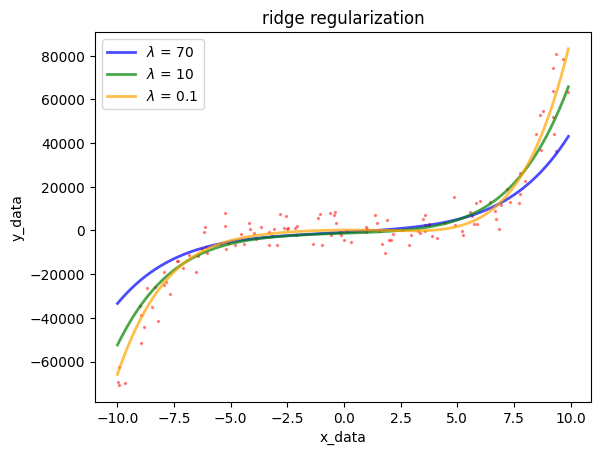

In [52]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x_points,y_points,alpha = 0.4,s = 2,color = "red")
ax.set_title("ridge regularization")
ax.plot(ref_x,poly_1_3,color = "blue",alpha = 0.7,lw = 2,label = r"$\lambda$ = 70")
ax.plot(ref_x,poly_2_3,color = "green",alpha = 0.7,lw = 2,label = r"$\lambda$ = 10")
ax.plot(ref_x,poly_3_3,color = "orange",alpha = 0.7,lw = 2,label = r"$\lambda$ = 0.1")
#ax.plot(ref_x,poly_4_2,color = "pink",alpha = 0.7,lw = 2,label = "sklearn")
ax.set_xlabel("x_data")
ax.set_ylabel("y_data")
ax.legend()
plt.show()

The most prominent diference is that lasso regression drives some coefficients to zero so it is good for overfitted models due to the dimension of features space. On the contrary ridge regression apply penalty for coefficients corresponding to very large degrees but it doesn't drive them to absolute zero. Generally speaking Ridge is better for models with a lot of noise, but big complexity, lasso is better for simple models in which we don't have any prior knowledge about dimension of feture space